resnet effnetb3 dene sadece 2024

only validate 2024 data

loss değiştir

farklı img_size ile model eğitip ensemble

2018-2019-2024 verileriyle egitilmis effnetb0 tabular modele ekle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle -q

In [ ]:
!pip install torcheval -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 14.6 MB/s eta 0:00:00


In [ ]:
from google.colab import files

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d nischaydnk/isic-2018-jpg-256x256-resized
# !kaggle datasets download -d nischaydnk/isic-2019-jpg-256x256-resized
# !mkdir -p ./data/isic-2018-256x256
# !mkdir -p ./data/isic-2019-256x256

# !unzip isic-2018-jpg-256x256-resized.zip -d ./data/isic-2018-256x256
# !unzip isic-2019-jpg-256x256-resized.zip -d ./data/isic-2019-256x256

# !ls ./data/isic-2018-256x256
# !ls ./data/isic-2019-256x256


In [ ]:
!kaggle --version

Kaggle API 1.6.17


In [ ]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [01:33<00:00, 24.0MB/s]
100% 2.00G/2.00G [01:33<00:00, 23.1MB/s]


In [ ]:
!mkdir -p ./data/isic-2024-challenge
!unzip isic-2024-challenge.zip -d ./data/isic-2024-challenge
!ls ./data/isic-2024-challenge

Streaming output truncated to the last 5000 lines.
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874659.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874663.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874742.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874751.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874803.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874805.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874832.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874878.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874897.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874925.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874931.jpg  
  inflating: ./data/isic-2024-challenge/train-image/image/ISIC_9874939.jpg  
  inflating: ./data/isic-

In [ ]:
!pip install timm -q

^C



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install albumentations -q

^C



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# import torch_xla
# import torch_xla.core.xla_model as xm
# from torch_xla.distributed.parallel_loader import MpDeviceLoader


# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# # For colored terminal text
# from colorama import Fore, Back, Style
# b_ = Fore.BLUE
# sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#!/bin/bash
!kaggle models instances versions download timm/tf-efficientnet/pyTorch/tf-efficientnet-b2/1

 93% 30.0M/32.4M [00:02<00:00, 14.9MB/s]
100% 32.4M/32.4M [00:02<00:00, 11.5MB/s]
/content/tf-efficientnet.tar.gz

In [ ]:
!mkdir -p ./data/model
!tar -xzvf tf-efficientnet.tar.gz -C ./data/model
!ls ./data/model

tf_efficientnet_b2_aa-60c94f97.pth
tf_efficientnet_b2_aa-60c94f97.pth


In [ ]:
CONFIG = {
    "seed": 42,
    "epochs": 15,
    "img_size": 336,
    "model_name": "eva02_small_patch14_336.mim_in22k_ft_in1k",
    # "model_name": "tf_efficientnet_b2_ns",
    # "checkpoint_path" : '/content/data/model/tf_efficientnet_b0_aa-827b6e33.pth',
    # "checkpoint_path" : '/content/data/model/tf_efficientnet_b3_aa-84b4657e.pth',
    # "checkpoint_path": '/content/data/model/tf_efficientnet_b2_aa-60c94f97.pth',
    "train_batch_size": 64,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR', ## warmup + cosine scheduler denenebilir. 1.olan notebook
    "min_lr": 1e-6,
    "T_max": 14,
    "T_0": 14,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

EFFNET = False
RESNET = False
EVA02 = True
RESNEST = False
RESNEXT = False
EDGENEXT = False

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])

In [ ]:
# ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = '/content/data/isic-2024-challenge/train-image/image'
# ISIC_2018_256 = '/content/data/isic-2018-256x256/train-image/image'
# ISIC_2019_256 = '/content/data/isic-2019-256x256/train-image/image'

In [ ]:
def get_file_path(image_id):
    potential_paths = [
        os.path.join(TRAIN_DIR, f"{image_id}.jpg")
        # os.path.join(ISIC_2018_256, f"{image_id}.jpg"),
        # os.path.join(ISIC_2019_256, f"{image_id}.jpg")
    ]
    for path in potential_paths:
        if os.path.exists(path):
            return path
    return None

In [ ]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
# train_2018_images = sorted(glob.glob(f"{ISIC_2018_256}/*.jpg"))
# train_2019_images = sorted(glob.glob(f"{ISIC_2019_256}/*jpg"))

# train_images = train_images + train_2019_images + train_2018_images
# train_images = train_images + train_2018_images

## DOWNSAMPLING THE POSITIVE CLASSES

In [ ]:
df = pd.read_csv("/content/data/isic-2024-challenge/train-metadata.csv")
df = df[['isic_id', 'patient_id', 'target']]
# df['is_ext'] = 0

# df_2018 = pd.read_csv('/content/data/isic-2018-256x256/train-metadata.csv')
# df_2018 = df_2018[['isic_id', 'patient_id', 'target']]
# df_2018['is_ext'] = 1

# df_2019 = pd.read_csv('/content/data/isic-2019-256x256/train-metadata.csv')
# df_2019 = df_2019[['isic_id', 'patient_id', 'target']]
# df_2019['is_ext'] = 1
# df = pd.concat([df, df_2019], ignore_index=True)
# df = pd.concat([df, df_2018], ignore_index=True)

print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

# df_positive = df[df["target"] == 1].reset_index(drop=True)
# df_negative = df[df["target"] == 0].reset_index(drop=True)

# df_negative_sample = df_negative.sample(n=df_positive.shape[0] * 20, random_state=42)
# df = pd.concat([df_positive, df_negative_sample]).reset_index(drop=True)


# df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_file_path)

df = df[df["file_path"].isin(train_images)].reset_index(drop=True)

print(df)

        df.shape, # of positive cases, # of patients
original> (401059, 3) 393 (1042,)
filtered> (401059, 3) 393 (1042,)
             isic_id  patient_id  target  \
0       ISIC_0015670  IP_1235828       0   
1       ISIC_0015845  IP_8170065       0   
2       ISIC_0015864  IP_6724798       0   
3       ISIC_0015902  IP_4111386       0   
4       ISIC_0024200  IP_8313778       0   
...              ...         ...     ...   
401054  ISIC_9999937  IP_1140263       0   
401055  ISIC_9999951  IP_5678181       0   
401056  ISIC_9999960  IP_0076153       0   
401057  ISIC_9999964  IP_5231513       0   
401058  ISIC_9999967  IP_6426047       0   

                                                file_path  
0       /content/data/isic-2024-challenge/train-image/...  
1       /content/data/isic-2024-challenge/train-image/...  
2       /content/data/isic-2024-challenge/train-image/...  
3       /content/data/isic-2024-challenge/train-image/...  
4       /content/data/isic-2024-challenge/train-im

In [ ]:
# df_positive.shape, df_negative.shape, df.shape, df_pos_2.shape, df_neg_2.shape

In [ ]:
CONFIG['T_max'] = 8253 * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

CONFIG['T_0'] = 8253 * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_0']

# 'T_max': int(cfg['train']['params']['num_epochs']*cfg['train']['params']['steps_per_epoch']), 2nd place
# T_max = 4 1.st place

1547

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd
import pandas.api.types

def compute_pauc(y_true, y_scores, tpr_threshold=0.80):

    v_gt = abs(np.asarray(y_true)-1)

    v_pred = -1.0 * np.asarray(y_scores)

    max_fpr = abs(1-tpr_threshold)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)

    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0,1), got: %r" % tpr_threshold)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]

    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return(partial_auc)

## CV SETUP TO AVOID LEAKAGE

In [ ]:
# sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

# for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
#       df.loc[val_ , "kfold"] = int(fold)


sgfk = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

df["kfold"] = -1

for fold, (train_idx, val_idx) in enumerate(sgfk.split(df, df.target, df.patient_id)):
    df.loc[val_idx, "kfold"] = int(fold)

In [ ]:
df['kfold'].tail()

,kfold
401054,4
401055,3
401056,1
401057,3
401058,0


## MODELLING

In [ ]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.df_positive = df[df["target"] == 1].reset_index(drop=True)
        self.df_negative = df[df["target"] == 0].reset_index(drop=True)
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        print(f"Length of df_positive: {len(self.df_positive)}")
        print(f"Length of df_negative: {len(self.df_negative)}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]

        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),

        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.RandomRotate90(p=0.5),

        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),

        A.OneOf([
          A.MotionBlur(blur_limit=5),
          A.MedianBlur(blur_limit=5),
          A.GaussianBlur(blur_limit=5),
          A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),
        A.OneOf([
          A.OpticalDistortion(distort_limit=1.0),
          A.GridDistortion(num_steps=5, distort_limit=1.),
          A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),

        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

        A.CoarseDropout(max_height=int(CONFIG['img_size']*0.375), max_width=int(CONFIG['img_size']*0.375), num_holes=1, p=0.7),

        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.1,
                           rotate_limit=15,
                           border_mode=0,
                           p=0.85),

        A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2),
                contrast_limit=(-0.2, 0.2),
                p=0.75
            ),

        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),

        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
if EFFNET:
    class ISICModel(nn.Module):
        def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
            super(ISICModel, self).__init__()
            self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

            in_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
            self.model.global_pool = nn.Identity()
            self.pooling = GeM()
            self.linear = nn.Linear(in_features, num_classes)
            self.sigmoid = nn.Sigmoid()

        def forward(self, images):
            features = self.model(images)
            pooled_features = self.pooling(features).flatten(1)
            output = self.sigmoid(self.linear(pooled_features))
            return output


if EVA02:
    class ISICModel(nn.Module):
        def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
            super(ISICModel, self).__init__()
            self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

            in_features = self.model.head.in_features
            self.model.head = nn.Linear(in_features, num_classes)
            self.sigmoid = nn.Sigmoid()

        def forward(self, images):
            return self.sigmoid(self.model(images))

if RESNET:
    class ISICModel(nn.Module):
        def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
            super(ISICModel, self).__init__()
            self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features, num_classes)
            self.sigmoid = nn.Sigmoid()

        def forward(self, images):
            return self.sigmoid(self.model(images))

if EDGENEXT:
    class ISICModel(nn.Module):
        def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
            super(ISICModel, self).__init__()

            self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, global_pool='avg')

            # Modify the classifier head to match the number of output classes
            in_features = self.model.get_classifier().in_features
            self.model.classifier = nn.Linear(in_features, num_classes)
            self.sigmoid = nn.Sigmoid()

        def forward(self, images):
            return self.sigmoid(self.model(images))

if RESNEST:
    class ISICModel(nn.Module):
        def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
            super(ISICModel, self).__init__()

            self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, global_pool='avg')

            # Modify the classifier head to match the number of output classes
            in_features = self.model.get_classifier().in_features
            self.model.classifier = nn.Linear(in_features, num_classes)
            self.sigmoid = nn.Sigmoid()

        def forward(self, images):
            return self.sigmoid(self.model(images))

if RESNEXT:

    class ISICModel(nn.Module):
        def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
            super(ISICModel, self).__init__()
            self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features, num_classes)
            self.sigmoid = nn.Sigmoid()

        def forward(self, images):
            return self.sigmoid(self.model(images))


model = ISICModel(CONFIG['model_name'], pretrained=True)
model.to(CONFIG['device']);

## FOCAL LOSS AND OTHER ALTERNATIVES FOR HANDLING IMBALANCE

In [ ]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.logits = logits
#         self.reduce = reduce

#     def forward(self, inputs, targets):
#         if self.logits:
#             BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         else:
#             BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduce:
#             return torch.mean(F_loss)
#         else:
#             return torch.sum(F_loss)

# def criterion(outputs, targets):
#     return FocalLoss()(outputs, targets)



def criterion(outputs, targets):

    ##could try focal loss.

    return nn.BCELoss()(outputs, targets)

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_pauc  = 0.0

    all_targets = []
    all_outputs = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()


        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        # all_targets.extend(targets.cpu().detach().numpy())
        # all_outputs.extend(outputs.cpu().detach().numpy())

        epoch_loss = running_loss / dataset_size

        all_targets.extend(targets.cpu().numpy())
        all_outputs.extend(outputs.cpu().detach().numpy())

        # current_pauc = compute_pauc(targets.cpu().numpy(), outputs.detach().cpu().numpy(), tpr_threshold=0.8)

        # running_pauc += (current_pauc * batch_size)
        # current_epoch_pauc = running_pauc / dataset_size

        # current_pauc = compute_pauc(np.array(all_targets), np.array(all_outputs), tpr_threshold=0.8)

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])

    # Compute partial AUC
    # all_targets = np.array(all_targets)
    # all_outputs = np.array(all_outputs)
    epoch_pauc = compute_pauc(all_targets, all_outputs, tpr_threshold=0.8)

    gc.collect()

    return epoch_loss, epoch_pauc

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_pauc = 0.0

    all_targets = []
    all_outputs = []

    all_targets_non_ext = []
    all_outputs_non_ext = []


    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        # is_ext = data['is_ext'].to(device)

        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        # non_ext_mask = is_ext == 0
        # all_targets_non_ext.extend(targets[non_ext_mask].cpu().detach().numpy())
        # all_outputs_non_ext.extend(outputs[non_ext_mask].cpu().detach().numpy())

        epoch_loss = running_loss / dataset_size
        all_targets.extend(targets.cpu().numpy())
        all_outputs.extend(outputs.cpu().detach().numpy())


        # current_pauc = compute_pauc(targets.cpu().numpy(), outputs.detach().cpu().numpy(), tpr_threshold=0.8)

        # running_pauc += (current_pauc * batch_size)
        # current_epoch_pauc = running_pauc / dataset_size


        # bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_pAUC=current_pauc,
        #                 LR=optimizer.param_groups[0]['lr'])

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])

    # Compute partial AUC
    # all_targets = np.array(all_targets)
    # all_outputs = np.array(all_outputs)
    epoch_pauc = compute_pauc(all_targets, all_outputs, tpr_threshold=0.8)

    # all_targets_non_ext = np.array(all_targets_non_ext)
    # all_outputs_non_ext = np.array(all_outputs_non_ext)
    # epoch_pauc_non_ext = compute_pauc(all_targets_non_ext, all_outputs_non_ext, tpr_threshold=0.8)


    gc.collect()

    return epoch_loss, epoch_pauc

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_pauc = -np.inf
    # best_epoch_pauc_non_ext = -np.inf

    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_pauc = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        val_epoch_loss, val_epoch_pauc = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train PAUC'].append(train_epoch_pauc)
        history['Valid PAUC'].append(val_epoch_pauc)
        # history['Valid PAUC non-ext'].append(val_epoch_pauc_non_ext)
        history['lr'].append( scheduler.get_lr()[0] )

        # deep copy the model
        if best_epoch_pauc <= val_epoch_pauc:
            print(f"Validation pAUC Improved ({best_epoch_pauc} ---> {val_epoch_pauc})")
            best_epoch_pauc = val_epoch_pauc
            # best_epoch_pauc_non_ext = val_epoch_pauc_non_ext
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "pAUC{:.4f}_Loss{:.4f}_epoch{:.0f}_fold{:.0f}.bin".format(val_epoch_pauc, val_epoch_loss, epoch, fold)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print("Model Saved")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best pAUC: {:.4f}".format(best_epoch_pauc))
    # print("Best pAUC non-ext: {:.4f}".format(best_epoch_pauc_non_ext))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_epoch_pauc

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler

class GradualWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step(self, epoch=None, metrics=None):
        if self.finished and self.after_scheduler:
            if epoch is None:
                self.after_scheduler.step(None)
            else:
                self.after_scheduler.step(epoch - self.total_epoch)
        else:
            return super(GradualWarmupScheduler, self).step(epoch)

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])

    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])

    elif CONFIG['scheduler'] == 'OneCycleLR':
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005,
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=1,
                                            pct_start=0.3,
                                            anneal_strategy='cos')

    elif CONFIG['scheduler'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.2,
                                                   patience=1,
                                                   min_lr=1e-6,
                                                   verbose=True)

    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    df_train_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_train_negative = df_train[df_train["target"] == 0].reset_index(drop=True)

    df_train_negative_sample = df_train_negative.sample(n=df_train_positive.shape[0] * 20, random_state=42)
    df_train = pd.concat([df_train_positive, df_train_negative_sample]).reset_index(drop=True)


    df = pd.concat([df_train, df_valid]).reset_index(drop=True)
    print(f'Number of training samples: {len(df_train)}')
    print(f'Number of validation samples: {len(df_valid)}')
    print(f'Total number of samples: {df.shape[0]}')

    train_dataset = ISICDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    print(f'Length of train_dataset: {len(train_dataset)}')
    print(f'Length of valid_dataset: {len(valid_dataset)}')

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],

                              num_workers=2, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],

                              num_workers=2, shuffle=False, pin_memory=True)


    print(f'Length of train_loader: {len(train_loader)}')
    print(f'Length of valid_loader: {len(valid_loader)}')

    return train_loader, valid_loader

Fold: 0
Number of training samples: 6510
Number of validation samples: 71164
Total number of samples: 77674
Length of train_dataset: 6510
Length of valid_dataset: 71164
Length of train_loader: 102
Length of valid_loader: 1112
[INFO] Using GPU: NVIDIA L4



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=1, LR=9.9e-5, Valid_Loss=0.06]


Validation pAUC Improved (-inf ---> 0.0258000587485209)
Model Saved



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=2, LR=9.59e-5, Valid_Loss=0.0289]


100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=3, LR=9.09e-5, Valid_Loss=0.0363]


Validation pAUC Improved (0.0258000587485209 ---> 0.027567328161000087)
Model Saved



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=4, LR=8.41e-5, Valid_Loss=0.0264]


100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=5, LR=7.59e-5, Valid_Loss=0.0316]


Validation pAUC Improved (0.027567328161000087 ---> 0.03129167250733635)
Model Saved



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=6, LR=6.66e-5, Valid_Loss=0.051]


Validation pAUC Improved (0.03129167250733635 ---> 0.046870709014643554)
Model Saved



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=7, LR=5.67e-5, Valid_Loss=0.0341]


100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=8, LR=4.64e-5, Valid_Loss=0.0432]


Validation pAUC Improved (0.046870709014643554 ---> 0.06438159893269563)
Model Saved



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=9, LR=3.64e-5, Valid_Loss=0.0301]


100%|██████████| 1112/1112 [08:09<00:00,  2.27it/s, Epoch=10, LR=2.69e-5, Valid_Loss=0.0227]


100%|██████████| 1112/1112 [08:09<00:00,  2.27it/s, Epoch=11, LR=1.85e-5, Valid_Loss=0.061]


Validation pAUC Improved (0.06438159893269563 ---> 0.11292530174721757)
Model Saved



100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=12, LR=1.14e-5, Valid_Loss=0.0414]


100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=13, LR=5.99e-6, Valid_Loss=0.0372]


100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=14, LR=2.49e-6, Valid_Loss=0.0443]


100%|██████████| 1112/1112 [08:10<00:00,  2.27it/s, Epoch=15, LR=1.04e-6, Valid_Loss=0.0483]



Training complete in 2h 39m 16s
Best pAUC: 0.1129


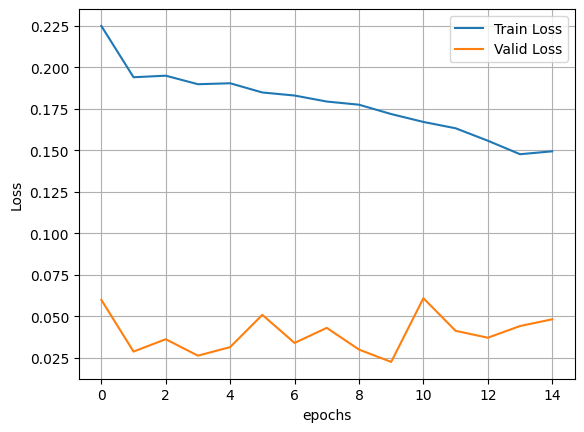

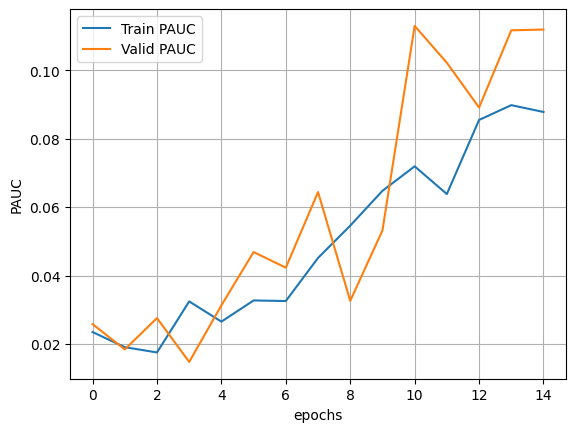

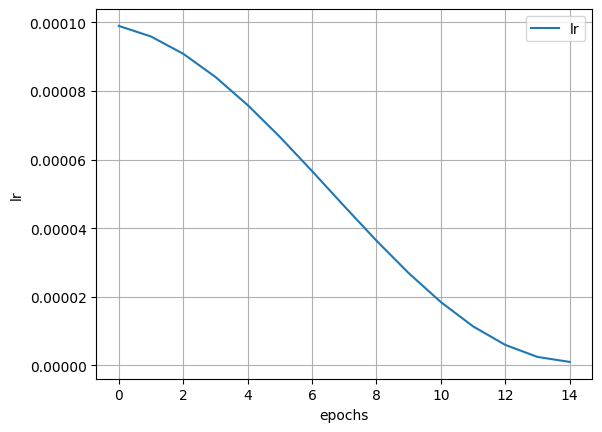

Fold: 1
Number of training samples: 6615
Number of validation samples: 87294
Total number of samples: 93909
Length of train_dataset: 6615
Length of valid_dataset: 87294
Length of train_loader: 104
Length of valid_loader: 1364
[INFO] Using GPU: NVIDIA L4



100%|██████████| 1364/1364 [10:02<00:00,  2.27it/s, Epoch=1, LR=9.89e-5, Valid_Loss=0.0603]


Validation pAUC Improved (-inf ---> 0.04858690066278122)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=2, LR=9.57e-5, Valid_Loss=0.0473]


100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=3, LR=9.05e-5, Valid_Loss=0.0231]


Validation pAUC Improved (0.04858690066278122 ---> 0.055434753209244104)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=4, LR=8.35e-5, Valid_Loss=0.0356]


Validation pAUC Improved (0.055434753209244104 ---> 0.07005136672170242)
Model Saved



100%|██████████| 1364/1364 [10:00<00:00,  2.27it/s, Epoch=5, LR=7.5e-5, Valid_Loss=0.0326]


100%|██████████| 1364/1364 [10:00<00:00,  2.27it/s, Epoch=6, LR=6.55e-5, Valid_Loss=0.0448]


Validation pAUC Improved (0.07005136672170242 ---> 0.0773632161118402)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=7, LR=5.53e-5, Valid_Loss=0.0731]


Validation pAUC Improved (0.0773632161118402 ---> 0.09278250814952793)
Model Saved



100%|██████████| 1364/1364 [10:00<00:00,  2.27it/s, Epoch=8, LR=4.48e-5, Valid_Loss=0.0271]


Validation pAUC Improved (0.09278250814952793 ---> 0.10745887604720844)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=9, LR=3.47e-5, Valid_Loss=0.0341]


Validation pAUC Improved (0.10745887604720844 ---> 0.1302531527971814)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=10, LR=2.52e-5, Valid_Loss=0.048]


100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=11, LR=1.68e-5, Valid_Loss=0.0367]


Validation pAUC Improved (0.1302531527971814 ---> 0.13493660302273397)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=12, LR=9.96e-6, Valid_Loss=0.0458]


Validation pAUC Improved (0.13493660302273397 ---> 0.13559920786117813)
Model Saved



100%|██████████| 1364/1364 [10:00<00:00,  2.27it/s, Epoch=13, LR=4.91e-6, Valid_Loss=0.0366]


Validation pAUC Improved (0.13559920786117813 ---> 0.14065294417867338)
Model Saved



100%|██████████| 1364/1364 [10:01<00:00,  2.27it/s, Epoch=14, LR=1.88e-6, Valid_Loss=0.0398]


Validation pAUC Improved (0.14065294417867338 ---> 0.14137061418982166)
Model Saved



100%|██████████| 1364/1364 [10:00<00:00,  2.27it/s, Epoch=15, LR=1.12e-6, Valid_Loss=0.0389]


Validation pAUC Improved (0.14137061418982166 ---> 0.14164799801494898)
Model Saved

Training complete in 3h 7m 35s
Best pAUC: 0.1416


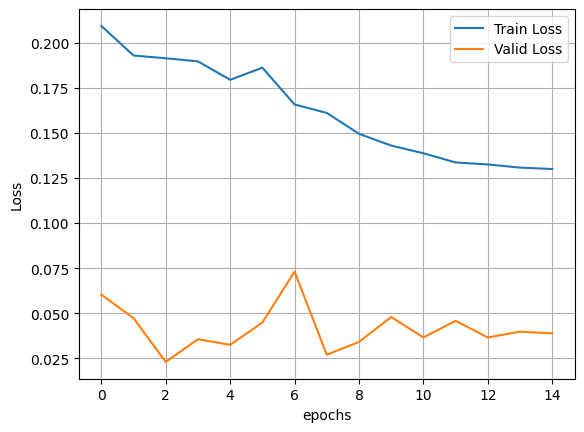

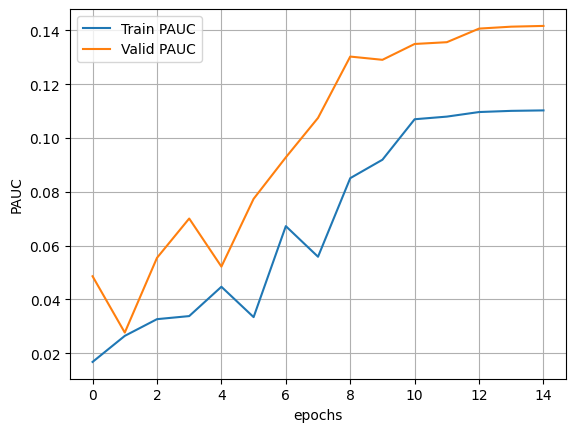

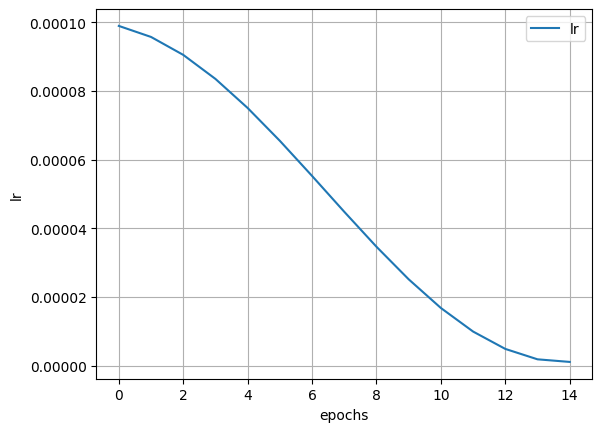

Fold: 2
Number of training samples: 6993
Number of validation samples: 77645
Total number of samples: 84638
Length of train_dataset: 6993
Length of valid_dataset: 77645
Length of train_loader: 110
Length of valid_loader: 1214
[INFO] Using GPU: NVIDIA L4



100%|██████████| 1214/1214 [08:54<00:00,  2.27it/s, Epoch=1, LR=9.88e-5, Valid_Loss=0.0212]


Validation pAUC Improved (-inf ---> 0.04650233077699725)
Model Saved



100%|██████████| 1214/1214 [08:54<00:00,  2.27it/s, Epoch=2, LR=9.52e-5, Valid_Loss=0.0231]


100%|██████████| 1214/1214 [08:54<00:00,  2.27it/s, Epoch=3, LR=8.94e-5, Valid_Loss=0.0297]


Validation pAUC Improved (0.04650233077699725 ---> 0.0920183239887435)
Model Saved



100%|██████████| 1214/1214 [08:54<00:00,  2.27it/s, Epoch=4, LR=8.17e-5, Valid_Loss=0.0402]


Validation pAUC Improved (0.0920183239887435 ---> 0.11097441515756908)
Model Saved



100%|██████████| 1214/1214 [08:54<00:00,  2.27it/s, Epoch=5, LR=7.24e-5, Valid_Loss=0.0355]


Validation pAUC Improved (0.11097441515756908 ---> 0.12238770380872589)
Model Saved



100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=6, LR=6.2e-5, Valid_Loss=0.0359]


Validation pAUC Improved (0.12238770380872589 ---> 0.1539535133509484)
Model Saved



100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=7, LR=5.11e-5, Valid_Loss=0.0195]


Validation pAUC Improved (0.1539535133509484 ---> 0.15723400141779978)
Model Saved



100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=8, LR=4.01e-5, Valid_Loss=0.0386]


100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=9, LR=2.96e-5, Valid_Loss=0.02]


100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=10, LR=2.02e-5, Valid_Loss=0.0308]


100%|██████████| 1214/1214 [08:54<00:00,  2.27it/s, Epoch=11, LR=1.23e-5, Valid_Loss=0.0343]


100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=12, LR=6.26e-6, Valid_Loss=0.0335]


Validation pAUC Improved (0.15723400141779978 ---> 0.16031793087151722)
Model Saved



100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=13, LR=2.44e-6, Valid_Loss=0.0323]


100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=14, LR=1.01e-6, Valid_Loss=0.0304]


100%|██████████| 1214/1214 [08:55<00:00,  2.27it/s, Epoch=15, LR=1.15e-5, Valid_Loss=0.0294]



Training complete in 2h 53m 9s
Best pAUC: 0.1603


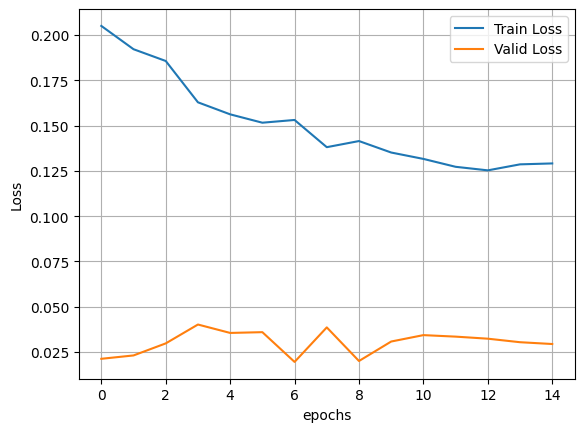

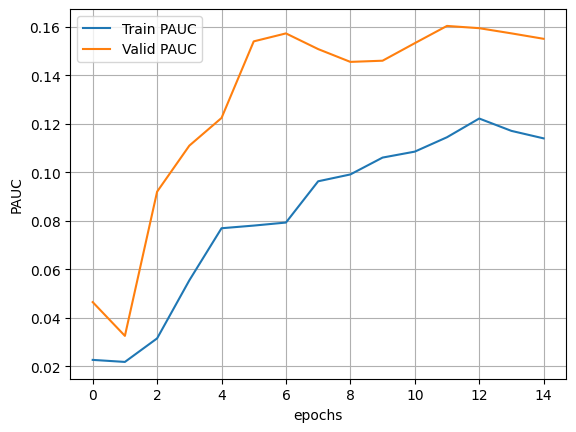

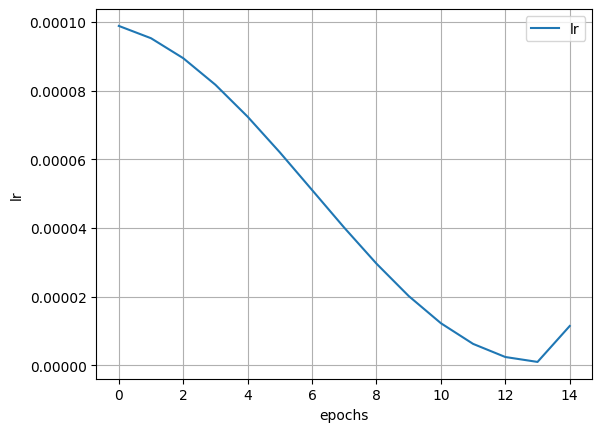

Fold: 3
Number of training samples: 6384
Number of validation samples: 83361
Total number of samples: 89745
Length of train_dataset: 6384
Length of valid_dataset: 83361
Length of train_loader: 100
Length of valid_loader: 1303
[INFO] Using GPU: NVIDIA L4



100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=1, LR=9.9e-5, Valid_Loss=0.0532]


Validation pAUC Improved (-inf ---> 0.02584426182614223)
Model Saved



100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=2, LR=9.61e-5, Valid_Loss=0.0526]


Validation pAUC Improved (0.02584426182614223 ---> 0.07707299538752654)
Model Saved



100%|██████████| 1303/1303 [09:33<00:00,  2.27it/s, Epoch=3, LR=9.12e-5, Valid_Loss=0.0515]


100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=4, LR=8.47e-5, Valid_Loss=0.0462]


Validation pAUC Improved (0.07707299538752654 ---> 0.08648039563860571)
Model Saved



100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=5, LR=7.68e-5, Valid_Loss=0.055]


100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=6, LR=6.78e-5, Valid_Loss=0.0304]


Validation pAUC Improved (0.08648039563860571 ---> 0.10438511508515208)
Model Saved



100%|██████████| 1303/1303 [09:33<00:00,  2.27it/s, Epoch=7, LR=5.81e-5, Valid_Loss=0.0483]


100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=8, LR=4.8e-5, Valid_Loss=0.0342]


Validation pAUC Improved (0.10438511508515208 ---> 0.1203566544077564)
Model Saved



100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=9, LR=3.81e-5, Valid_Loss=0.0336]


100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=10, LR=2.87e-5, Valid_Loss=0.0306]


Validation pAUC Improved (0.1203566544077564 ---> 0.12357281026251046)
Model Saved



100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=11, LR=2.02e-5, Valid_Loss=0.0425]


100%|██████████| 1303/1303 [09:35<00:00,  2.27it/s, Epoch=12, LR=1.29e-5, Valid_Loss=0.0251]


Validation pAUC Improved (0.12357281026251046 ---> 0.1260578302484561)
Model Saved



100%|██████████| 1303/1303 [09:35<00:00,  2.27it/s, Epoch=13, LR=7.19e-6, Valid_Loss=0.0337]


Validation pAUC Improved (0.1260578302484561 ---> 0.13018563235575087)
Model Saved



100%|██████████| 1303/1303 [09:34<00:00,  2.27it/s, Epoch=14, LR=3.25e-6, Valid_Loss=0.0325]


Validation pAUC Improved (0.13018563235575087 ---> 0.13398235483338203)
Model Saved



100%|██████████| 1303/1303 [09:33<00:00,  2.27it/s, Epoch=15, LR=1.24e-6, Valid_Loss=0.0341]


Validation pAUC Improved (0.13398235483338203 ---> 0.13407344659602047)
Model Saved

Training complete in 2h 59m 36s
Best pAUC: 0.1341


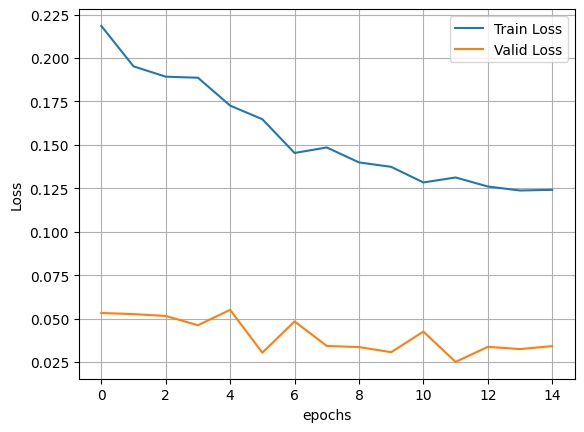

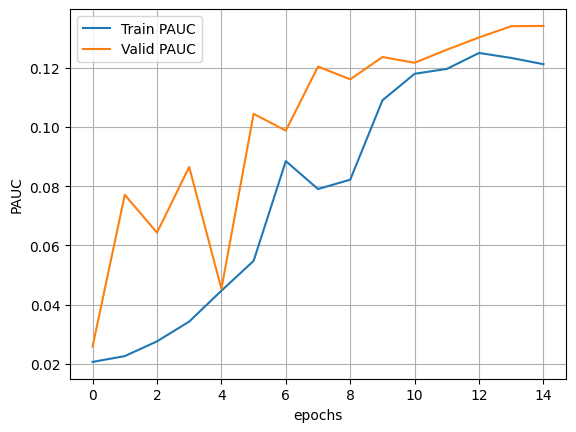

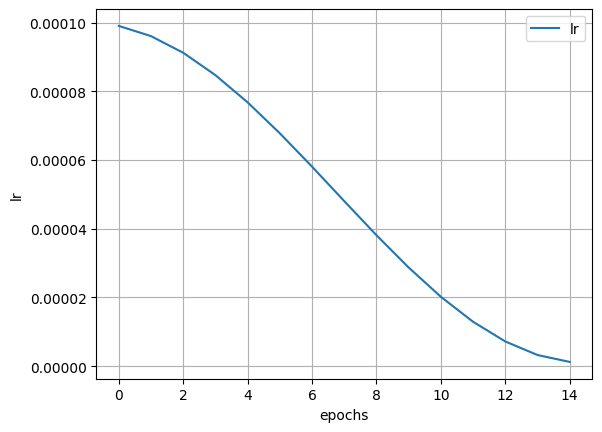

Fold: 4
Number of training samples: 6510
Number of validation samples: 81595
Total number of samples: 88105
Length of train_dataset: 6510
Length of valid_dataset: 81595
Length of train_loader: 102
Length of valid_loader: 1275
[INFO] Using GPU: NVIDIA L4



100%|██████████| 1275/1275 [09:21<00:00,  2.27it/s, Epoch=1, LR=9.9e-5, Valid_Loss=0.0711]


Validation pAUC Improved (-inf ---> 0.04136750653610614)
Model Saved



100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=2, LR=9.59e-5, Valid_Loss=0.0368]


Validation pAUC Improved (0.04136750653610614 ---> 0.043553495560414185)
Model Saved



100%|██████████| 1275/1275 [09:21<00:00,  2.27it/s, Epoch=3, LR=9.09e-5, Valid_Loss=0.0629]


Validation pAUC Improved (0.043553495560414185 ---> 0.08289166086270686)
Model Saved



100%|██████████| 1275/1275 [09:23<00:00,  2.26it/s, Epoch=4, LR=8.41e-5, Valid_Loss=0.083]


100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=5, LR=7.59e-5, Valid_Loss=0.037]


Validation pAUC Improved (0.08289166086270686 ---> 0.11535503088021924)
Model Saved



100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=6, LR=6.66e-5, Valid_Loss=0.0584]


Validation pAUC Improved (0.11535503088021924 ---> 0.12659092548425122)
Model Saved



100%|██████████| 1275/1275 [09:21<00:00,  2.27it/s, Epoch=7, LR=5.67e-5, Valid_Loss=0.0498]


Validation pAUC Improved (0.12659092548425122 ---> 0.12923457496686122)
Model Saved



100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=8, LR=4.64e-5, Valid_Loss=0.0284]


Validation pAUC Improved (0.12923457496686122 ---> 0.14039984651531828)
Model Saved



100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=9, LR=3.64e-5, Valid_Loss=0.0317]


100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=10, LR=2.69e-5, Valid_Loss=0.0314]


100%|██████████| 1275/1275 [09:23<00:00,  2.26it/s, Epoch=11, LR=1.85e-5, Valid_Loss=0.0558]


100%|██████████| 1275/1275 [09:22<00:00,  2.26it/s, Epoch=12, LR=1.14e-5, Valid_Loss=0.0284]


Validation pAUC Improved (0.14039984651531828 ---> 0.14244484070347532)
Model Saved



100%|██████████| 1275/1275 [09:22<00:00,  2.27it/s, Epoch=13, LR=5.99e-6, Valid_Loss=0.0422]


Validation pAUC Improved (0.14244484070347532 ---> 0.1433658079171135)
Model Saved



100%|██████████| 1275/1275 [09:23<00:00,  2.26it/s, Epoch=14, LR=2.49e-6, Valid_Loss=0.0401]


Validation pAUC Improved (0.1433658079171135 ---> 0.1435578263589247)
Model Saved



100%|██████████| 1275/1275 [09:23<00:00,  2.26it/s, Epoch=15, LR=1.04e-6, Valid_Loss=0.042]



Training complete in 2h 57m 22s
Best pAUC: 0.1436


In [ ]:
pauc_scores = []
pauc_scores_non_ext = []

oof_targets = []
oof_predictions = []

for fold in range(CONFIG['n_fold']):
    print(f"Fold: {fold}")
    train_loader, valid_loader = prepare_loaders(df, fold=fold)


    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);

    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
                           weight_decay=CONFIG['weight_decay'])

    # optimizer = optim.Adam(model.parameters(), lr=0.00001)

    scheduler_cosine = fetch_scheduler(optimizer) ############
    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine) ######

    # scheduler = fetch_scheduler(optimizer)

    model, history, best_epoch_pauc  = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)

    val_targets = []
    val_predictions = []

    model.eval()
    with torch.inference_mode():
        for data in valid_loader:
            images = data['image'].to(CONFIG['device'], dtype=torch.float)
            targets = data['target'].to(CONFIG['device'], dtype=torch.float)

            outputs = model(images).squeeze()
            val_targets.extend(targets.cpu().numpy())
            val_predictions.extend(outputs.cpu().numpy())

    oof_targets.extend(val_targets)
    oof_predictions.extend(val_predictions)

    pauc_scores.append(best_epoch_pauc)
    # pauc_scores_non_ext.append(best_epoch_pauc_non_ext)

    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"history_{fold}.csv", index=False)
    plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
    plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

    plt.plot(range(history.shape[0]), history["Train PAUC"].values, label="Train PAUC")
    plt.plot(range(history.shape[0]), history["Valid PAUC"].values, label="Valid PAUC")
    # plt.plot(range(history.shape[0]), history["Valid PAUC non-ext"].values, label="Valid PAUC non-ext")
    plt.xlabel("epochs")
    plt.ylabel("PAUC")
    plt.grid()
    plt.legend()
    plt.show()

    plt.plot(range(history.shape[0]), history["lr"].values, label="lr")
    plt.xlabel("epochs")
    plt.ylabel("lr")
    plt.grid()
    plt.legend()
    plt.show()

print(f"Mean PAUC: {np.mean(pauc_scores)}")
print(f"Std PAUC: {np.std(pauc_scores)}")

oof_pauc = compute_pauc(np.array(oof_targets), np.array(oof_predictions), tpr_threshold=0.8)
print(f"OOF PAUC: {oof_pauc}")

# print(f"Mean PAUC non-ext: {np.mean(pauc_scores_non_ext)}")
# print(f"Std PAUC non-ext: {np.std(pauc_scores_non_ext)}")

# effnetb0-5fold Mean PAUC: 0.1541151329587102
# Std PAUC: 0.009240496729855495



In [ ]:
# train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])


# # train_loader = MpDeviceLoader(train_loader, CONFIG['device'])
# # valid_loader = MpDeviceLoader(valid_loader, CONFIG['device'])

In [ ]:

# optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
#                        weight_decay=CONFIG['weight_decay'])
# scheduler = fetch_scheduler(optimizer)

In [ ]:
# model, history = run_training(model, optimizer, scheduler,
#                               device=CONFIG['device'],
#                               num_epochs=CONFIG['epochs'])

In [ ]:
# history = pd.DataFrame.from_dict(history)
# history.to_csv("history.csv", index=False)
# # 0.1582

In [ ]:
## LEARNING RATE AYARLARINA BAK
## KAZANAN COZUMLER NASIL SAMPLE KULLANMIS BAK.

In [ ]:
# plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
# plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
# plt.xlabel("epochs")
# plt.ylabel("Loss")
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
# plt.plot( range(history.shape[0]), history["Train PAUC"].values, label="Train PAUC")
# plt.plot( range(history.shape[0]), history["Valid PAUC"].values, label="Valid PAUC")
# plt.xlabel("epochs")
# plt.ylabel("PAUC")
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
# plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
# plt.xlabel("epochs")
# plt.ylabel("lr")
# plt.grid()
# plt.legend()
# plt.show()